In [8]:
from collections import OrderedDict
import re

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"


import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import ipywidgets
import ipdb
from plot_utils import get_model_names_for_degree

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

['big_lr00005' 'chebyshev_deg_1_11_no_noise' 'chebyshev_deg_1_4_no_noise'
 'chebyshev_deg_1_8_no_noise' 'chebyshev_linear_regression_toy'
 'chebyshev_linear_regression_toy_standard_0.00005_lr_no_noise_no_curriculum'
 'curriculum' 'decision_tree_pretrained' 'eight_to_eleven' 'four_to_eight'
 'kernel_linear_regression_toy' 'linear_regression_pretrained' 'lr00001'
 'lr00005' 'lr0005' 'lr001' 'one_to_eleven' 'one_to_four'
 'relu_2nn_regression_pretrained' 'sparse_regression_pretrained'
 'with_curriculum']
                                  run_id                      task  \
1   13a76f74-c060-465a-b2c5-d2467a4c4fbf  kernel_linear_regression   
21  d26ba40f-6a42-4b87-9522-9004337fdfe3  kernel_linear_regression   
4   53a1f304-84bc-4ff1-b56a-0af7b63b16fc  kernel_linear_regression   
13  253acdb8-dee5-4773-a53e-db780cc792c0  kernel_linear_regression   
23  51884322-51eb-4d53-82bf-37e9f71890b7  kernel_linear_regression   
25  2462910b-ff80-450b-9fa7-fcb1994ccb08  kernel_linear_regression   
34 

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,13a76f74-c060-465a-b2c5-d2467a4c4fbf,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,24,16,big_lr00005
21,d26ba40f-6a42-4b87-9522-9004337fdfe3,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,24,16,big_lr00005
4,53a1f304-84bc-4ff1-b56a-0af7b63b16fc,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,24,16,big_lr00005
13,253acdb8-dee5-4773-a53e-db780cc792c0,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,24,16,big_lr00005
23,51884322-51eb-4d53-82bf-37e9f71890b7,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,24,16,big_lr00005
25,2462910b-ff80-450b-9fa7-fcb1994ccb08,kernel_linear_regression,Transformer,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,12,8,chebyshev_deg_1_11_no_noise
34,a87e1832-4d2a-4026-8938-09c08ae676b9,kernel_linear_regression,Transformer,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,12,8,chebyshev_deg_1_4_no_noise
33,ecbab875-f3b5-4e26-8e63-5dc0ec817120,kernel_linear_regression,Transformer,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,12,8,chebyshev_deg_1_8_no_noise
22,3f2e6984-340c-472d-b982-d73c45f0eefb,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,chebyshev_linear_regression_toy
14,d6bea011-c8ef-4719-85b5-726c21fe8b09,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,chebyshev_linear_regression_toy


../models/kernel_linear_regression/small-0.5x-0.0005lr-1-11basis/metrics.json
0.2
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
torch.Size([64, 41, 2])
0.2
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
torch.Size([64, 41, 3])
to

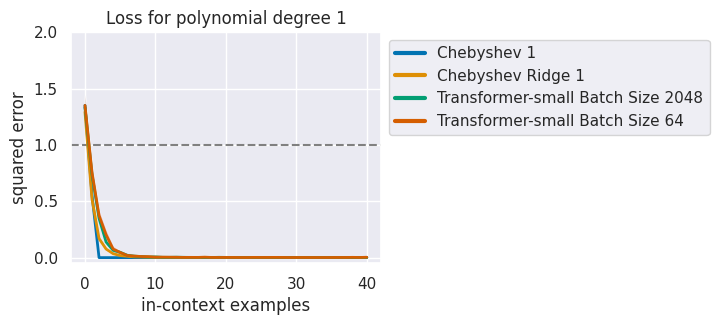

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 4', 'Chebyshev Ridge 4', 'Transformer-small Batch Size 2048', 'Transformer-small Batch Size 64'])


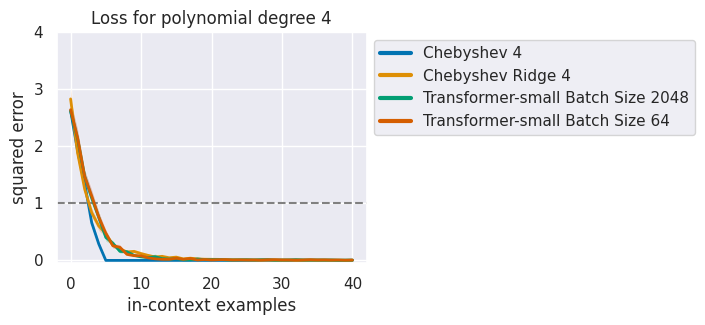

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 8', 'Chebyshev Ridge 8', 'Transformer-small Batch Size 2048', 'Transformer-small Batch Size 64'])


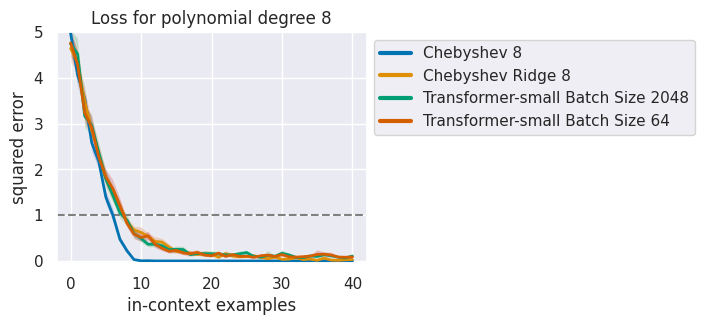

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 11', 'Chebyshev Ridge 11', 'Transformer-small Batch Size 2048', 'Transformer-small Batch Size 64'])


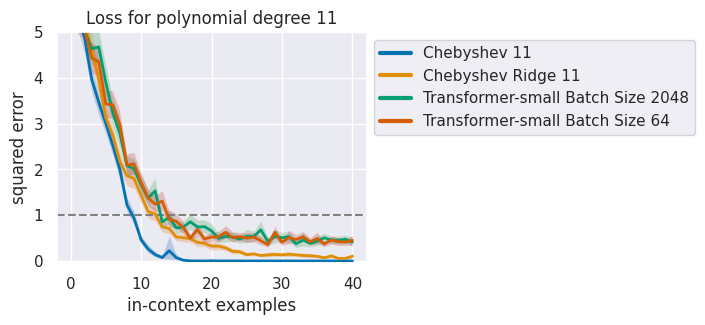

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 1', 'Chebyshev Ridge 1', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


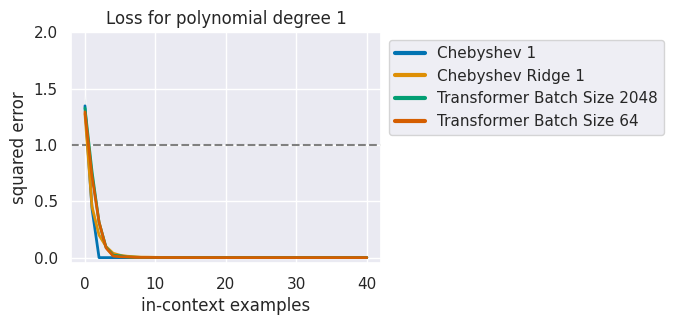

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 4', 'Chebyshev Ridge 4', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


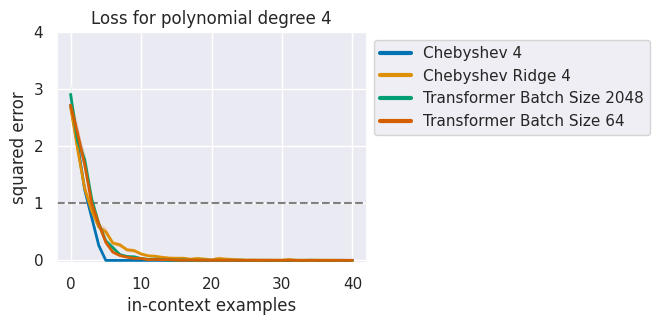

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 8', 'Chebyshev Ridge 8', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


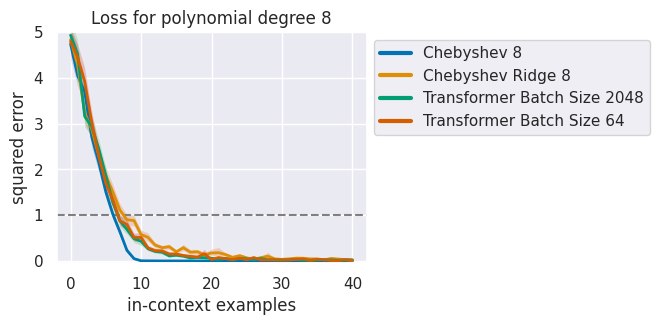

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 11', 'Chebyshev Ridge 11', 'Transformer Batch Size 2048', 'Transformer Batch Size 64'])


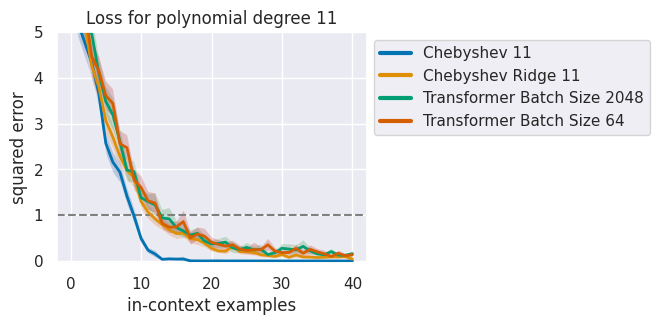

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 1', 'Chebyshev Ridge 1', 'Transformer-plus Batch Size 2048', 'Transformer-plus Batch Size 64'])


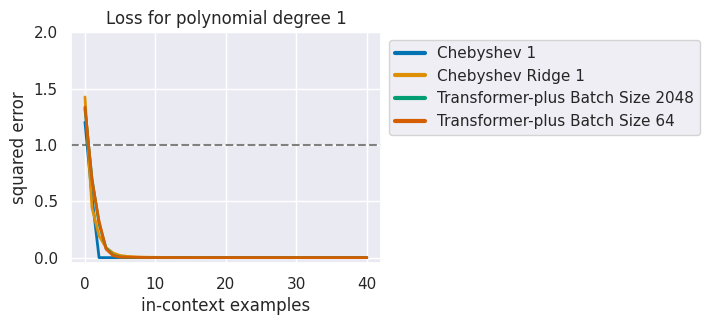

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 4', 'Chebyshev Ridge 4', 'Transformer-plus Batch Size 2048', 'Transformer-plus Batch Size 64'])


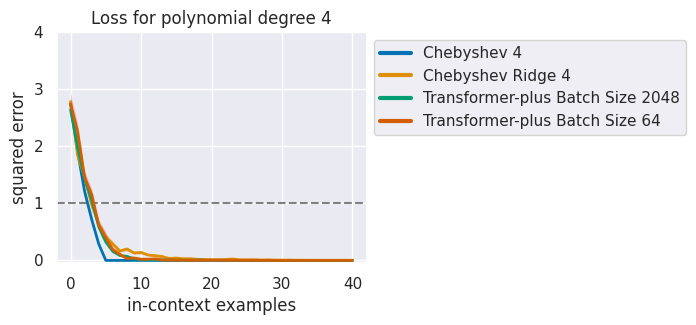

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 8', 'Chebyshev Ridge 8', 'Transformer-plus Batch Size 2048', 'Transformer-plus Batch Size 64'])


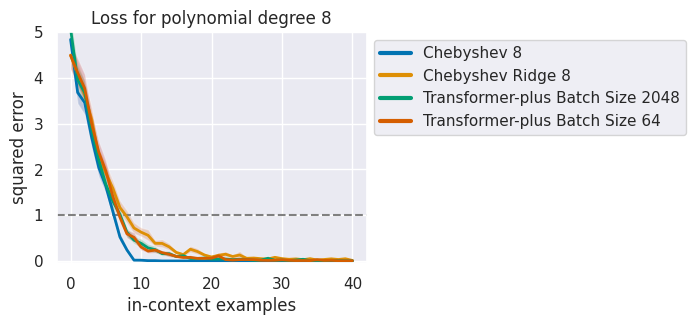

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 11', 'Chebyshev Ridge 11', 'Transformer-plus Batch Size 2048', 'Transformer-plus Batch Size 64'])


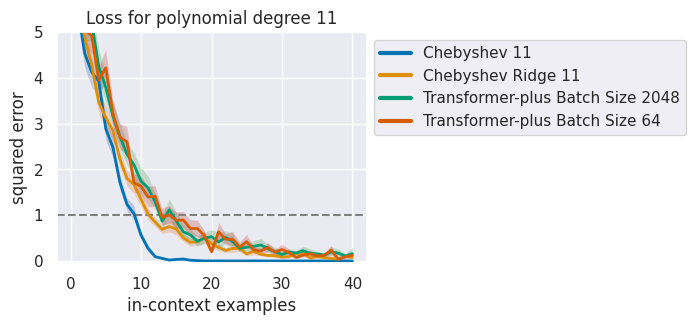

In [11]:

def valid_row(r, run_id):
    return r.task == task and r.run_id == run_id

task = "kernel_linear_regression"

run_ids = ['small-0.5x-0.0005lr-1-11basis',  'standard-0.00005-lr-no-noise', '2x-big-no-noise']

# run_names = ['chebyshev_deg_1_4_no_noise','chebyshev_deg_1_8_no_noise','chebyshev_deg_1_11_no_noise']

# run_ids = [df[df.run_name == run_name].run_id.values[0] for run_name in run_names]
run_paths = [os.path.join(run_dir, task, run_id) for run_id in run_ids]
metrics = [get_run_metrics(run_path, run_path, None, include_noise=False, ground_truth_loss=False, smoothing=0.00) for run_path in run_paths]

metrics = [collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.00) for run_id in run_ids]
confs = [get_model_from_run(run_path, only_conf=True)[1] for run_path in run_paths]
n_dims = [conf.model.n_dims for conf in confs]

def plot_metrics(metrics, n_dims, title=None, ax=None, degrees=range(1,12), **kwargs):
    ylims = [2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5]
    for degree in degrees:
        models = get_model_names_for_degree(degree)
        print(models)
        print(metrics.keys())
        print(metrics["degree-" + str(degree)].keys())
        basic_plot(metrics["degree-" + str(degree)], models=models, ylim=ylims[degree-1])
        plt.title("Loss for polynomial degree " + str(degree))
        plt.savefig(f"graphs/{title}-degree-{str(degree)}.png", dpi=300, bbox_inches='tight')
        plt.show()

degrees=[1,4,8,11]
for run_name, run_metrics in zip(run_ids, metrics):
    plot_metrics(run_metrics, n_dims, title=run_name, degrees=degrees)



# Plot pre-computed metrics

chebyshev_linear_regression_toy micro-0.25x-just-quadratic-batch-2048-5M-steps
../models/kernel_linear_regression/micro-0.25x-just-quadratic-batch-2048-5M-steps/metrics.json
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
{'degree-1': {'chebyshev_1_driver=None': {'mean': [1.3481365442276, 0.47679853439331055, 1.9735697451284118e-11, 6.078576091908192e-14, 9.406763020435027e-14, 2.0549979835751513e-14, 1.5765304169014678e-14, 3.054562760498522e-14], 'std': [1.933719515800476, 1.0660696029663086, 5.862665353184582e-10, 4.928569488291124e-13, 3.2210838813925835e-13, 6.050538623727716e-14, 3.9239617821316616e-14, 7.193251121704117e-14], 'bootstrap_low': [1.2715224027633667, 0.43370959162712097, 1.1042281455528324e-12, 4.259609768316082e-14, 8.270754280016376e-14, 1.807128021714694e-14, 1.4095712444484043e-14, 2.7824253046992292e-14], 'bootstrap_high': [1.4343247413635254, 0.5212172865867615, 4.853934962301132e-11, 8.62140965714707e-14, 1.0950528678277394e-13, 2.335302192238691e-14, 1.747589398

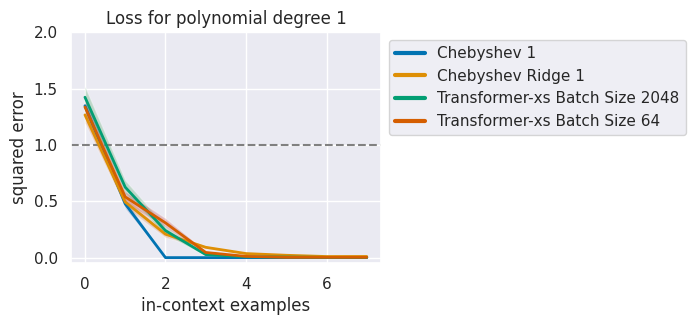

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 2', 'Chebyshev Ridge 2', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


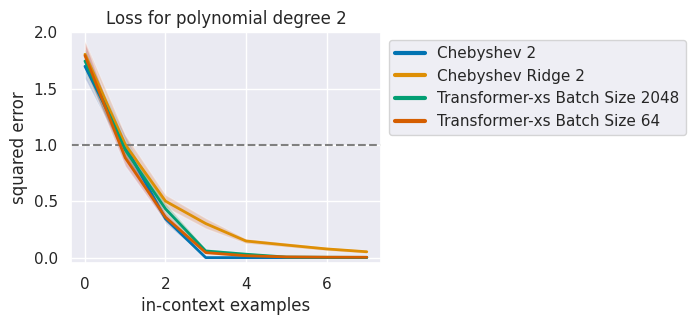

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 3', 'Chebyshev Ridge 3', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


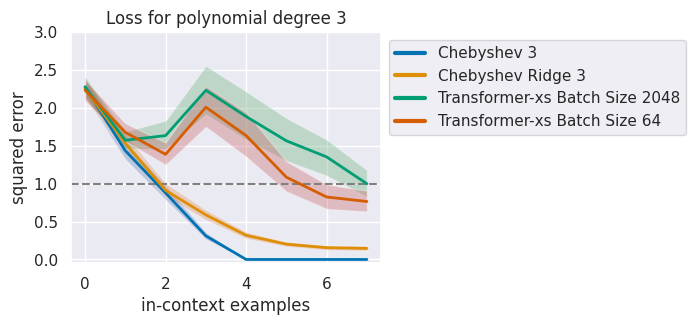

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 4', 'Chebyshev Ridge 4', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


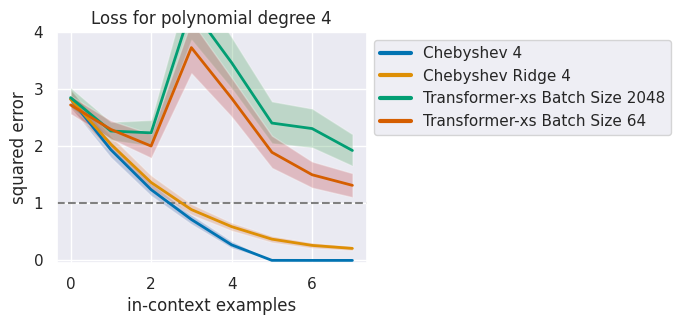

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 5', 'Chebyshev Ridge 5', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


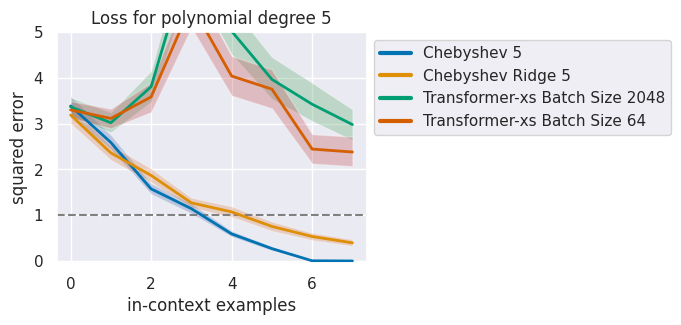

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 6', 'Chebyshev Ridge 6', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


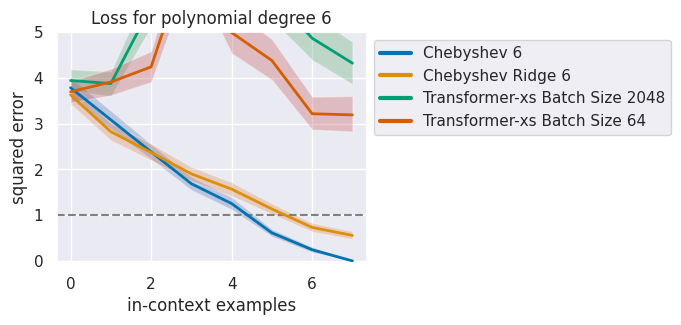

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 7', 'Chebyshev Ridge 7', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


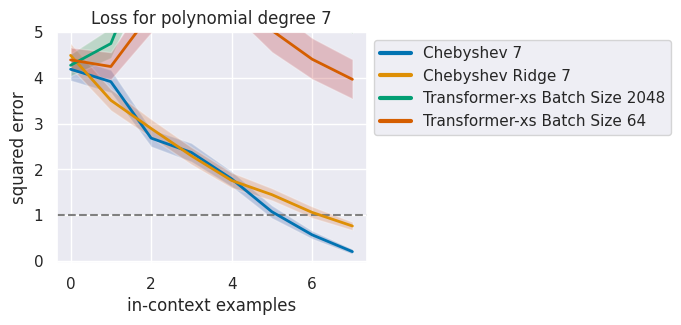

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 8', 'Chebyshev Ridge 8', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


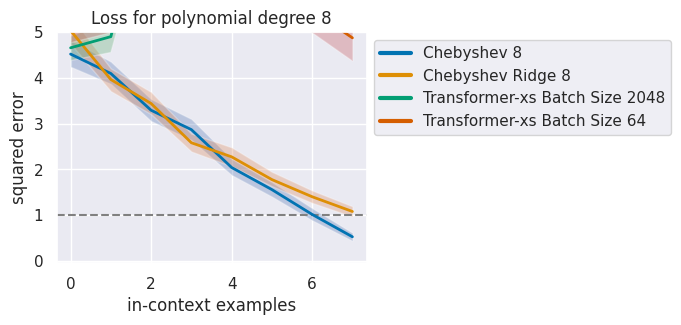

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 9', 'Chebyshev Ridge 9', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


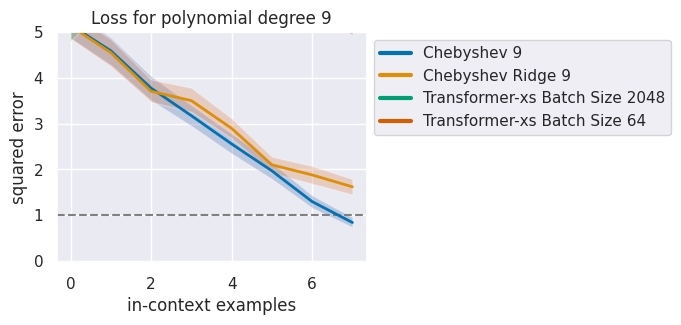

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 10', 'Chebyshev Ridge 10', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


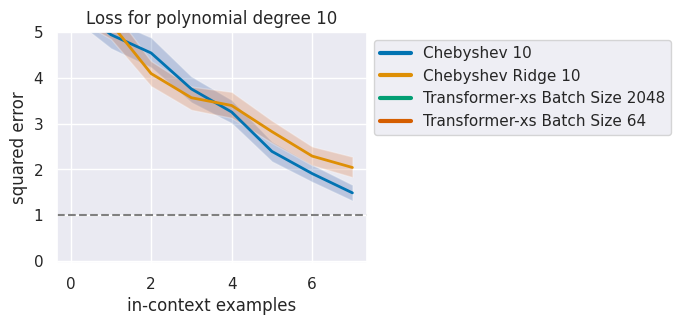

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 11', 'Chebyshev Ridge 11', 'Transformer-xs Batch Size 2048', 'Transformer-xs Batch Size 64'])


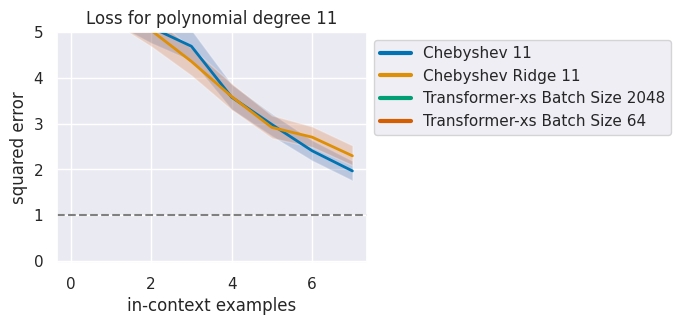

In [9]:


metrics = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.00)
print(metrics["degree-" + str(1)])
#metrics_smooth = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.01)
#metrics_big = collect_results(run_dir, df, valid_row= lambda x: valid_row(x, run_id_big), smoothing=0.00)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

#for k, v in metrics_big.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2] = v2
#for k, v in metrics_smooth.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2+ " Smoothed"] = v2

ylims = [2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5]
for degree in range(1, 12):
    models = get_model_names_for_degree(degree)
    print(models)
    print(metrics.keys())
    print(metrics["degree-" + str(degree)].keys())
    basic_plot(metrics["degree-" + str(degree)], models=models, ylim=ylims[degree-1])
    plt.title("Loss for polynomial degree " + str(degree))
    plt.savefig("graphs/degree-" + str(degree) + ".png", dpi=300, bbox_inches='tight')
    plt.show()